Training Final Model...
----------------------------------------
FINAL TEST RESULTS
R2 Score: 0.6478
MAE: 0.184
RMSE: 0.23
----------------------------------------


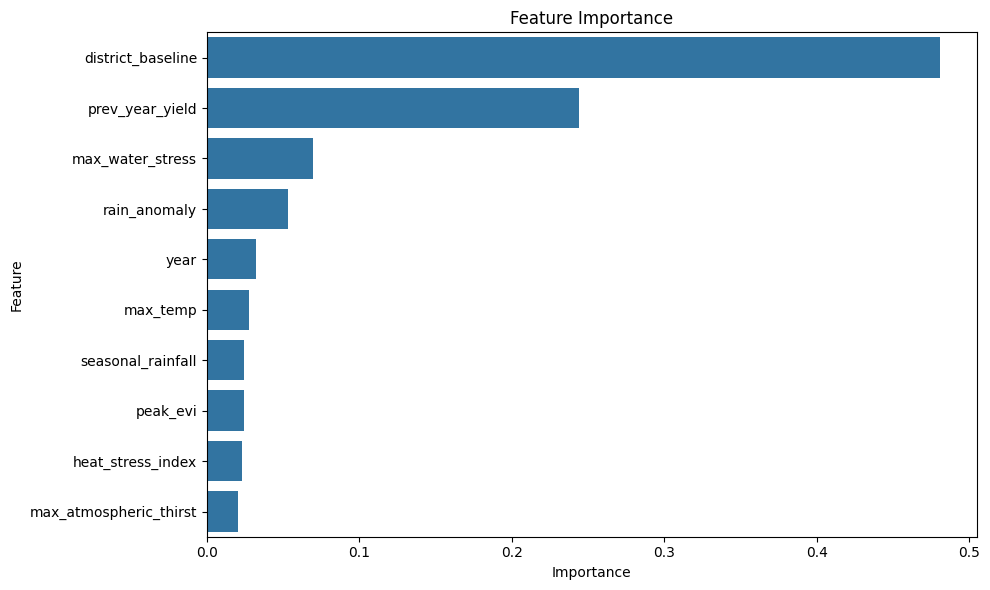

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib

# ==========================================
# 1. LOAD FINAL DATASET
# ==========================================

df = pd.read_csv("finaldata.csv")

df["district"] = df["district"].str.lower().str.strip()

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================

df = df.sort_values(by=["district", "year"])

# Memory Features
df["prev_year_yield"] = df.groupby("district")["yield"].shift(1)
df["prev_year_rain"] = df.groupby("district")["seasonal_rainfall"].shift(1)

# Physics Interaction
df["heat_stress_index"] = df["max_temp"] / (df["seasonal_rainfall"] + 1.0)

# Create rainfall anomaly (since it doesn't exist)
df["rain_anomaly"] = (
    df["seasonal_rainfall"] - 
    df.groupby("district")["seasonal_rainfall"].transform("mean")
)

df = df.dropna()

# ==========================================
# 3. TRAIN TEST SPLIT
# ==========================================

train = df[df["year"] <= 2011].copy()
test = df[df["year"] > 2011].copy()

# Target Encoding (Spatial Baseline)
district_means = train.groupby("district")["yield"].mean()
global_mean = train["yield"].mean()

train["district_baseline"] = train["district"].map(district_means)
test["district_baseline"] = test["district"].map(district_means).fillna(global_mean)

# ==========================================
# 4. FINAL MODEL TRAINING
# ==========================================

features = [
    "district_baseline",
    "prev_year_yield",
    "peak_evi",
    "max_water_stress",
    "max_atmospheric_thirst",
    "year",
    "heat_stress_index",
    "rain_anomaly",
    "seasonal_rainfall",
    "max_temp"
]

X_train = train[features]
y_train = train["yield"]

X_test = test[features]
y_test = test["yield"]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=2,
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)

print("Training Final Model...")
model.fit(X_train, y_train)

# ==========================================
# 5. EVALUATION
# ==========================================

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("-" * 40)
print("FINAL TEST RESULTS")
print("R2 Score:", round(r2, 4))
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("-" * 40)

# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================

importances = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importances)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()



In [2]:
import os
import joblib

base_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
model_path = os.path.join(base_dir, "models", "rf_model.pkl")

joblib.dump(model, model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: E:\agri-vision-ai\models\rf_model.pkl
